# Final Project

## Environment Setup

In [2]:
import os
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoFeatureExtractor, AutoModel

## Custom DogVsAi Dataset Class

In [3]:
class DogVsAiDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, "Images")
        self.label_dir = os.path.join(root_dir, "Labels")
        self.transform = transform
        self.image_names = [f.split('.')[0] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, name + '.jpg')
        label_path = os.path.join(self.label_dir, name + '.txt')

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        with open(label_path, 'r') as f:
            label = int(f.read().strip())

        return image, label

## ViT Feature Extractor Setup: Image Transformations and DINO Model Initialization

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dino_model_name = "facebook/dino-vits16"
feature_extractor = AutoFeatureExtractor.from_pretrained(dino_model_name)
dino_model = AutoModel.from_pretrained(dino_model_name).to(device)
dino_model.eval()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=384, out_features=1536, bias=True)
          (intermediate_act_fn): GELUAct

## Feature Extraction Pipeline and Dataset Processing

In [5]:
# ======================
# Feature Engineering
# ======================
def extract_and_save_features(dataloader, name_prefix):
    all_features = []
    all_labels = []

    for images, labels in tqdm(dataloader, desc=f"Extracting {name_prefix}"):
        images = [transforms.ToPILImage()(img) for img in images]
        inputs = feature_extractor(images=images, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            outputs = dino_model(**inputs)
            features = outputs.last_hidden_state.mean(dim=1)

        all_features.append(features.cpu())
        all_labels.append(labels)

    all_features = torch.cat(all_features)
    all_labels = torch.cat(all_labels)

    save_path = f"features_{name_prefix}.pt"
    torch.save((all_features, all_labels), save_path)
    print(f"Saved: {save_path} | Shape: {all_features.shape}")

# ======================
# Process dataset
# ======================
def process_dataset(base_path, suffix):
    print(f"\n=== Processing dataset: {suffix.upper()} ===")
    train_dataset = DogVsAiDataset(os.path.join(base_path, "Train"), transform=transform)
    val_dataset   = DogVsAiDataset(os.path.join(base_path, "Valid"), transform=transform)
    test_dataset  = DogVsAiDataset(os.path.join(base_path, "Test"), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

    print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

    extract_and_save_features(train_loader, f"train_{suffix}")
    extract_and_save_features(val_loader, f"val_{suffix}")
    extract_and_save_features(test_loader, f"test_{suffix}")

# ======================
# Get features
# ======================
process_dataset("/Users/qihuizhang/Desktop/archive/Dogs Vs AiDogs", "full")
# process_dataset("yourpath/archive/Dogs Vs AiDogs_CUTTED", "cutted")


=== Processing dataset: FULL ===
Train: 18605 | Val: 5317 | Test: 2658


Extracting train_full:   0%|          | 0/1163 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTFeatureExtractor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Extracting train_full: 100%|██████████| 1163/1163 [05:36<00:00,  3.46it/s]


Saved: features_train_full.pt | Shape: torch.Size([18605, 384])


Extracting val_full: 100%|██████████| 333/333 [01:40<00:00,  3.30it/s]


Saved: features_val_full.pt | Shape: torch.Size([5317, 384])


Extracting test_full: 100%|██████████| 167/167 [00:51<00:00,  3.27it/s]

Saved: features_test_full.pt | Shape: torch.Size([2658, 384])


In [6]:
features, labels = torch.load("features_train_full.pt")
print(features.shape)

torch.Size([18605, 384])


# Simple CNN Architecture with Dropout

In [7]:
import torch.nn as nn
import torchvision.models as models

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(384, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

def load_model(model_type="simple", num_classes=2, dropout_rate=0.5):
    return SimpleCNN(num_classes, dropout_rate)

# Simple CNN Model Training and Evaluation

Epoch 1: Train Acc = 0.9481, Train Loss = 0.1445 | Val Acc = 0.9844, Val Loss = 0.0481
Epoch 2: Train Acc = 0.9722, Train Loss = 0.0826 | Val Acc = 0.9870, Val Loss = 0.0407
Epoch 3: Train Acc = 0.9768, Train Loss = 0.0656 | Val Acc = 0.9851, Val Loss = 0.0404
Epoch 4: Train Acc = 0.9786, Train Loss = 0.0618 | Val Acc = 0.9897, Val Loss = 0.0338
Epoch 5: Train Acc = 0.9798, Train Loss = 0.0577 | Val Acc = 0.9902, Val Loss = 0.0291
Epoch 6: Train Acc = 0.9820, Train Loss = 0.0537 | Val Acc = 0.9904, Val Loss = 0.0300
Epoch 7: Train Acc = 0.9822, Train Loss = 0.0535 | Val Acc = 0.9921, Val Loss = 0.0247
Epoch 8: Train Acc = 0.9838, Train Loss = 0.0458 | Val Acc = 0.9934, Val Loss = 0.0250
Epoch 9: Train Acc = 0.9846, Train Loss = 0.0419 | Val Acc = 0.9910, Val Loss = 0.0251
Epoch 10: Train Acc = 0.9872, Train Loss = 0.0392 | Val Acc = 0.9898, Val Loss = 0.0275


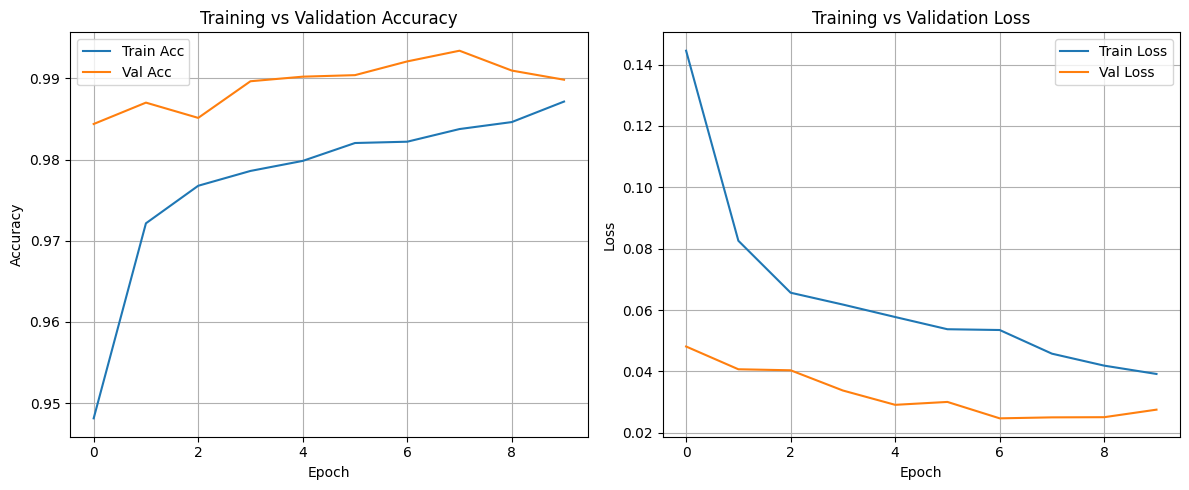

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# load features, labels, dataset
features_train, labels_train = torch.load("features_train_full.pt")
features_val, labels_val = torch.load("features_val_full.pt")

train_dataset = TensorDataset(features_train, labels_train)
val_dataset = TensorDataset(features_val, labels_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# load model
model = SimpleCNN(num_classes=2, dropout_rate=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# training loop
train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_preds, train_labels = [], []
    epoch_train_loss = 0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        train_preds += outputs.argmax(dim=1).cpu().tolist()
        train_labels += batch_y.cpu().tolist()

    train_acc = accuracy_score(train_labels, train_preds)
    train_acc_list.append(train_acc)
    train_loss_list.append(epoch_train_loss / len(train_loader))

    # validation
    model.eval()
    val_preds, val_labels = [], []
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            epoch_val_loss += loss.item()

            val_preds += outputs.argmax(dim=1).cpu().tolist()
            val_labels += batch_y.cpu().tolist()

    val_acc = accuracy_score(val_labels, val_preds)
    val_acc_list.append(val_acc)
    val_loss_list.append(epoch_val_loss / len(val_loader))

    print(f"Epoch {epoch+1}: "
          f"Train Acc = {train_acc:.4f}, Train Loss = {train_loss_list[-1]:.4f} | "
          f"Val Acc = {val_acc:.4f}, Val Loss = {val_loss_list[-1]:.4f}")

# save model
torch.save(model.state_dict(), "simple_cnn_model.pt")

# plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

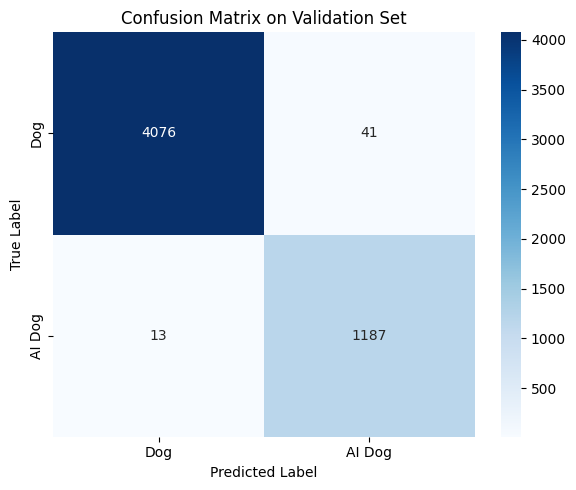

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

# confusion matrix
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dog", "AI Dog"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Dog", "AI Dog"], yticklabels=["Dog", "AI Dog"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Validation Set")
plt.tight_layout()
plt.show()

In [14]:
# === Evaluate on test set ===
features_test, labels_test = torch.load("features_test_full.pt")
test_dataset = TensorDataset(features_test, labels_test)
test_loader = DataLoader(test_dataset, batch_size=32)

model.eval()

test_preds, test_labels = [], []
test_loss_total = 0
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        test_loss_total += loss.item()
        test_preds += outputs.argmax(dim=1).cpu().tolist()
        test_labels += batch_y.cpu().tolist()

test_acc = accuracy_score(test_labels, test_preds)
test_loss = test_loss_total / len(test_loader)

print(f"Test Accuracy = {test_acc:.4f}, Test Loss = {test_loss:.4f}")

Test Accuracy = 0.9872, Test Loss = 0.0337
